In [1]:
import xarray as xr

#### Questions:
- Why are lat & lon different lengths?
- Is it conventional to only have 1 value (coordinate?) for the time dimension?
- Is it conventional to have `projection` as a data variable?
- ~Could I open_mfdataset for the 2018 and 2015 for same return period?~
  - Check with Deltares
- Time encoded as 2010-01-01, expected time-since
- Could I open_mf for multiple return periods, but single time dimension? Is this a new dimension?
- Am I doing anything meaningful with my chunking, should I just use `'auto'`?
- In order to read directly on blob, does this need to be Zarr
  - Is that what we're doing for all netcdf datasets?

In [2]:
import h5py

ds = xr.open_dataset("data/GFM_global_MERIT1km_2018slr_rp0000.nc", chunks={"lat": 1000, "lon": 1000})
ds



,Array,Chunk
Bytes,2.44 GB,4.00 MB
Shape,"(1, 15660, 38880)","(1, 1000, 1000)"
Count,625 Tasks,624 Chunks
Type,float32,numpy.ndarray


In [3]:
from shapely.geometry import shape

nola_geojson = {

        "type": "Polygon",
        "coordinates": [
          [
            [-91.730, 29.123],
            [-89.296, 29.123],
            [-89.296, 30.045],
            [-91.730, 30.045],
            [-91.730, 29.123]
          ]
        ]
    }

sfl_geojson = {
        "type": "Polygon",
        "coordinates": [
          [
            [-82.11181640625, 24.467150664739002],
            [-79.69482421875, 24.467150664739002],
            [-79.69482421875, 26.31311263768267],
            [-82.11181640625, 26.31311263768267],
            [-82.11181640625, 24.467150664739002]
          ]
        ]
      }

sfl_geojson_1 = {
        "type": "Polygon",
        "coordinates": [
          [
            [-82.2271728515625,25.854280326572407],
            [-81.1834716796875,25.854280326572407],
            [-81.1834716796875,26.534479888888043],
            [-82.2271728515625,26.534479888888043],
            [-82.2271728515625,25.854280326572407]
          ]
        ]
      }

poly = shape(sfl_geojson)
minx, miny, maxx, maxy = poly.bounds

#### Crop the array to a specified geo-area
- Is this a reasonable mechanism?
- If I wanted a non-bbox polygon, would I have to rasterize a vector and do a mask?

In [21]:
ds = ds.sel(lat=slice(miny, maxy), lon=slice(minx, maxx))
ds.dims

Frozen(SortedKeysDict({'time': 1, 'lat': 200, 'lon': 261}))

In [22]:
# Not dropping much - can I trim this further here?
ds.where(ds.inun.notnull(), drop=True)

<xarray.Dataset>
Dimensions:     (lat: 194, lon: 209, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2010-01-01
  * lat         (lat) float64 24.52 24.53 24.54 24.55 ... 26.28 26.29 26.3 26.31
  * lon         (lon) float64 -82.11 -82.1 -82.01 ... -80.08 -79.73 -79.72
Data variables:
    projection  (time, lat, lon) object dask.array<chunksize=(1, 194, 209), meta=np.ndarray>
    inun        (time, lat, lon) float32 dask.array<chunksize=(1, 194, 209), meta=np.ndarray>
Attributes:
    source:       Global Tide and Surge Model v3.0 - ERA5
    institution:  Deltares
    title:        GFM - MERIT 1km - 2018 slr - 0000-year return level
    references:   https://www.deltares.nl/en/
    Conventions:  CF-1.6
    project:      Microsoft Planetary Computer - Global Flood Maps
    config_file:  /p/temp/globalRuns/MERIT_1km/run_rp0000_slr2018/coastal_inu...
    history:      Created by: $Id: coastal_inun.py 528 2018-06-19 08:41:05Z e...

#### Visualize the coastal flooding amount
- ~Can I plot with cartopy or other maps?~
- How large an area is effecient to plot, and could Dask improve that?

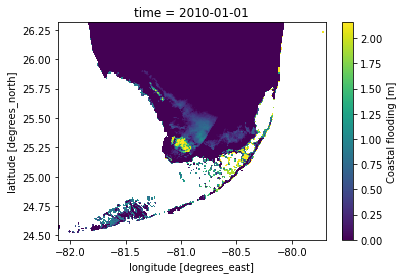

In [23]:
import matplotlib.colors as colors
ds.inun.isel(time=0).plot()

#### Distribution of flooding amount by cell
- Effectively by area
- Mostly not flooded

(array([15698.,   873.,   525.,   364.,   379.,   161.,    93.,    92.,
          127.,   218.]),
 array([0.        , 0.21559772, 0.43119544, 0.6467932 , 0.8623909 ,
        1.0779886 , 1.2935864 , 1.5091841 , 1.7247818 , 1.9403795 ,
        2.1559772 ], dtype=float32),
 <BarContainer object of 10 artists>)

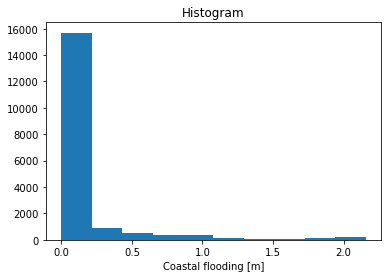

In [24]:
ds.inun.plot.hist()

#### Select only flooded area

In [25]:
flooded = ds.where(ds.inun > 0, drop=True)
flooded

<xarray.Dataset>
Dimensions:     (lat: 170, lon: 205, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2010-01-01
  * lat         (lat) float64 24.52 24.53 24.54 24.55 ... 26.2 26.23 26.24 26.25
  * lon         (lon) float64 -82.11 -82.1 -82.01 ... -80.08 -79.73 -79.72
Data variables:
    projection  (time, lat, lon) object dask.array<chunksize=(1, 170, 205), meta=np.ndarray>
    inun        (time, lat, lon) float32 dask.array<chunksize=(1, 170, 205), meta=np.ndarray>
Attributes:
    source:       Global Tide and Surge Model v3.0 - ERA5
    institution:  Deltares
    title:        GFM - MERIT 1km - 2018 slr - 0000-year return level
    references:   https://www.deltares.nl/en/
    Conventions:  CF-1.6
    project:      Microsoft Planetary Computer - Global Flood Maps
    config_file:  /p/temp/globalRuns/MERIT_1km/run_rp0000_slr2018/coastal_inu...
    history:      Created by: $Id: coastal_inun.py 528 2018-06-19 08:41:05Z e...

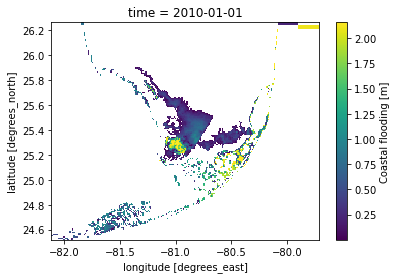

In [26]:
flooded.inun.isel(time=0).plot()

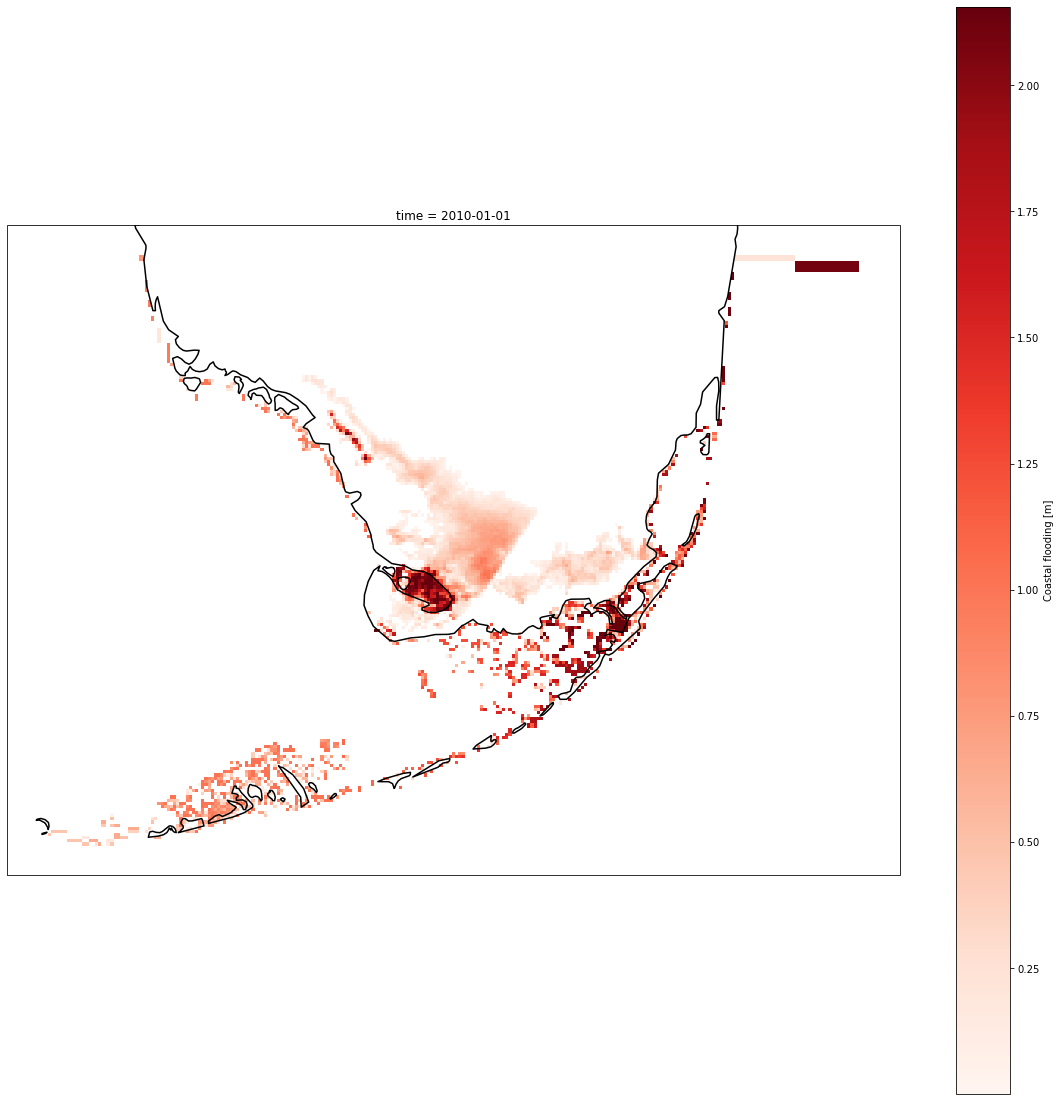

In [33]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig, axis = plt.subplots(
    1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
    figsize=(20,20)
)

flooded.inun.isel(time=0).plot(
    ax=axis,
    transform=ccrs.PlateCarree(),
    cmap="Reds"
    #robust=True, # outliers

)
axis.coastlines(color="black", linewidth=1.5)
